In [35]:
import pandas as pd
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings("ignore")
from math import sqrt

In [3]:
#Time Series Data Components 
from statsmodels.tsa.seasonal import seasonal_decompose 

In [4]:
#Augumented Dickey fuller test for dat stationarity 
from statsmodels.tsa.stattools import adfuller,acf,pacf

In [7]:
#difference
from statsmodels.tsa.statespace.tools import diff

In [11]:
#ARMA/ARIMA model
from statsmodels.tsa.arima_model import ARIMA

In [13]:
#MSE
from sklearn.metrics import mean_squared_error

In [14]:
#Ljung-Box Test
import statsmodels.api as sts

In [15]:
filename = "TradeInventories.csv"

In [17]:
data = pd.read_csv(filename,index_col = 'date',parse_dates =True)

In [18]:
data

,inventories
date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294
...,...
2018-08-01,2127170
2018-09-01,2134172
2018-10-01,2144639


Text(0.5, 1.0, 'Trade Inventories')

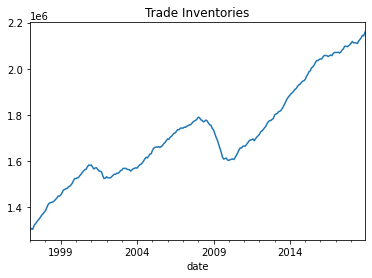

In [22]:
#plot the graph to check stationarity 
data.inventories.plot()
plt.title("Trade Inventories")

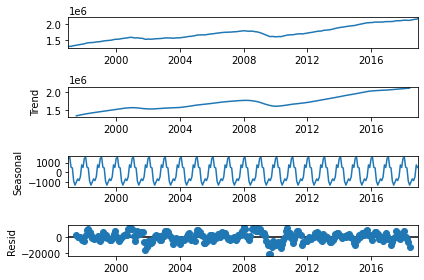

In [23]:
#Check for the TS components 
seasonal_decompose(data).plot();

In [25]:
#adf test to check data stationarity 
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    
    if(pvalue<0.05):
        print("data is Stationary")
    else:
        print("data is Not Stationary")

In [26]:
checkStationarity(data)

data is Not Stationary


#### Since there is a trend , detrend the data before  forecast 

In [27]:
data['diffata1'] = diff(data['inventories'],k_diff = 1)

In [28]:
data.head()

,inventories,diffata1
date,,
1997-01-01,1301161,NaN
1997-02-01,1307080,5919.0
1997-03-01,1303978,-3102.0
1997-04-01,1319740,15762.0
1997-05-01,1327294,7554.0


In [30]:
checkStationarity(data.diffata1.dropna())

data is Stationary


In [31]:
#d = 1 

In [32]:
diffdata = data.diffata1.dropna()
diffdata

date
1997-02-01     5919.0
1997-03-01    -3102.0
1997-04-01    15762.0
1997-05-01     7554.0
1997-06-01     7394.0
               ...   
2018-08-01     7552.0
2018-09-01     7002.0
2018-10-01    10467.0
2018-11-01    -1638.0
2018-12-01    15114.0
Name: diffata1, Length: 263, dtype: float64

In [36]:

#Since lags are not known , start with a radnom number for lags 
lag_pacf = pacf(diffdata,nlags = 40)
lag_acff = acf(diffdata,nlags = 40)
N = len(diffdata)
SE = 1.96 /sqrt(N)

Text(0.5, 1.0, 'PACF')

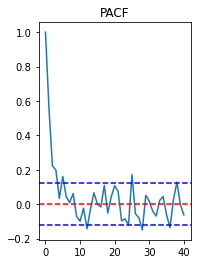

In [38]:
#plot PACF and ACF to determine significant lags (i.e p and q valeus for AR(p) and MA(q))
#PACF
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle = '--' , color ='red')
plt.axhline(y=-SE,linestyle = '--' , color ='blue')
plt.axhline(y=SE,linestyle = '--' , color ='blue')
plt.title("PACF")

Text(0.5, 1.0, 'Acf')

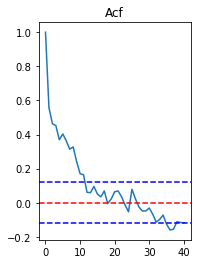

In [44]:
#PACF
plt.subplot(122)
plt.plot(lag_acff)
plt.axhline(y=0,linestyle = '--' , color ='red')
plt.axhline(y=-SE,linestyle = '--' , color ='blue')
plt.axhline(y=SE,linestyle = '--' , color ='blue')
plt.title("Acf")

In [46]:
#Tak random value for p and q 
p = 1 ; d = 1 ; q = 1 
#ARIMA(1,1,1) model 

#Split the data into train and test
train = data.inventories.iloc[:225]
test = data.inventories.iloc[225:]

In [49]:
train.tail(3)

date
2015-07-01    2008314
2015-08-01    2014926
2015-09-01    2026759
Name: inventories, dtype: int64

In [48]:
test.head(3)

date
2015-10-01    2035079
2015-11-01    2034881
2015-12-01    2040092
Name: inventories, dtype: int64

In [50]:
m1 = ARIMA(train,order =(p,d,q)).fit()

In [51]:
#summarise the model 
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.inventories   No. Observations:                  224
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2220.362
Method:                       css-mle   S.D. of innovations           4874.455
Date:                Sat, 17 Dec 2022   AIC                           4448.723
Time:                        10:44:09   BIC                           4462.370
Sample:                    02-01-1997   HQIC                          4454.232
                         - 09-01-2015                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3526.8760   1565.695      2.253      0.024     458.171    6595.581
ar.L1.D.inventories     0.9096      0.039     23.384      0.000       0.833       0.986
ma.L1.D.inventories    -0.5504      0.081     -6.796      0.000      -0.709      -0.392
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0993           +0.0000j            1.0993            0.0000
MA.1            1.8167           +0.0000j            1.8167            0.0000
-----------------------------------------------------------------------------
"""

In [52]:
#build model with loops ruuning from p and q 

In [53]:
aic,bic= m1.aic,m1.bic

In [54]:
print(aic)

4448.723331013957


In [55]:
print(bic)

4462.369915221378


In [59]:
#ljung-Box test for significance 
pval =sts.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True).lb_pvalue.values[0]

In [60]:
if (pval>0.05):
    print("GOOD")
else:
    print("BAD")

GOOD


In [61]:
#Forecast on test data
start =len(train)
end = len(train) + len(test) -1 
f1 = m1.predict(start,end,typ='levels')#typ='levels' will forecast in its orignal form
print(f1)

2015-10-01    2.034834e+06
2015-11-01    2.042498e+06
2015-12-01    2.049788e+06
2016-01-01    2.056738e+06
2016-02-01    2.063379e+06
2016-03-01    2.069739e+06
2016-04-01    2.075842e+06
2016-05-01    2.081712e+06
2016-06-01    2.087371e+06
2016-07-01    2.092837e+06
2016-08-01    2.098128e+06
2016-09-01    2.103259e+06
2016-10-01    2.108246e+06
2016-11-01    2.113100e+06
2016-12-01    2.117835e+06
2017-01-01    2.122460e+06
2017-02-01    2.126986e+06
2017-03-01    2.131422e+06
2017-04-01    2.135776e+06
2017-05-01    2.140055e+06
2017-06-01    2.144266e+06
2017-07-01    2.148415e+06
2017-08-01    2.152508e+06
2017-09-01    2.156550e+06
2017-10-01    2.160545e+06
2017-11-01    2.164498e+06
2017-12-01    2.168412e+06
2018-01-01    2.172292e+06
2018-02-01    2.176139e+06
2018-03-01    2.179958e+06
2018-04-01    2.183750e+06
2018-05-01    2.187518e+06
2018-06-01    2.191265e+06
2018-07-01    2.194991e+06
2018-08-01    2.198700e+06
2018-09-01    2.202392e+06
2018-10-01    2.206069e+06
2

In [65]:
#store the results in DF
dfres = pd.DataFrame({'actual':test.values,'forecast':f1.values})

In [66]:
dfres

,actual,forecast
0,2035079,2.034834e+06
1,2034881,2.042498e+06
2,2040092,2.049788e+06
3,2042452,2.056738e+06
4,2042254,2.063379e+06
5,2051480,2.069739e+06
6,2057157,2.075842e+06
7,2057546,2.081712e+06
8,2056598,2.087371e+06
9,2052876,2.092837e+06


In [68]:
mse = mean_squared_error(dfres.actual,dfres.forecast)
rmse= sqrt(mse)

In [69]:
print("Model 1 ")

Model 1 


In [70]:
print('p={} , d={} , q ={}'.format(p,d,q))

p=1 , d=1 , q =1


In [71]:
print("MSE={} , RMSE={}".format(mse,rmse))

MSE=3010695317.742762 , RMSE=54869.803332459305


Text(0.5, 1.0, 'Actual vs Forecast')

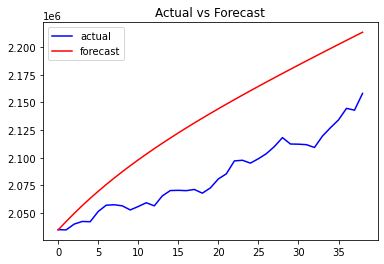

In [72]:
#plot the 
dfres.actual.plot(color="blue",legend = True)
dfres.forecast.plot(color="red",legend = True)
plt.title("Actual vs Forecast")

In [73]:
#Future Forecast 
#build model on full dataset .Give the future time period as parameter
m2 = ARIMA(data.inventories,order=(p,d,q)).fit()
f2 = m2.predict(start = len(data), end= len(data)+12,typ='levels')

In [74]:
data.tail(2)
print(pd.DataFrame(f2))

                       0
2019-01-01  2.165600e+06
2019-02-01  2.172696e+06
2019-03-01  2.179438e+06
2019-04-01  2.185862e+06
2019-05-01  2.191998e+06
2019-06-01  2.197873e+06
2019-07-01  2.203514e+06
2019-08-01  2.208942e+06
2019-09-01  2.214178e+06
2019-10-01  2.219240e+06
2019-11-01  2.224145e+06
2019-12-01  2.228909e+06
2020-01-01  2.233545e+06


In [75]:
#plot the actual and future forecast data
f2 =pd.DataFrame(f2)

In [76]:
f2

,0
2019-01-01,2.165600e+06
2019-02-01,2.172696e+06
2019-03-01,2.179438e+06
2019-04-01,2.185862e+06
2019-05-01,2.191998e+06
2019-06-01,2.197873e+06
2019-07-01,2.203514e+06
2019-08-01,2.208942e+06
2019-09-01,2.214178e+06
2019-10-01,2.219240e+06


In [77]:
f2.columns =['forecast']

Text(0.5, 1.0, 'Actual vs Forecast ')

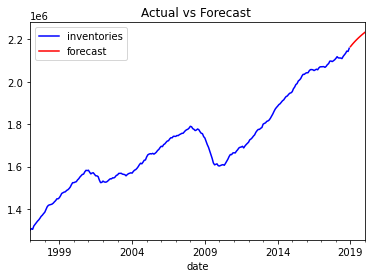

In [79]:
data.inventories.plot(color='blue',legend=True)
f2.forecast.plot(color='red',legend=True)
plt.title('Actual vs Forecast ')

In [80]:
import numpy as np 
lis_p = np.arange(0,5)
lis_q = np.arange(0,3)

In [82]:
for i in len(lis_p):
    for j in len(lis_q):
        model = ARIMA(train,order =(lis_p(i),d,lis_q(j))).fit()
        aic.bic=model.aic,model.bic

TypeError: 'int' object is not iterable